In [1]:
from lagrangian import LagrangianSolver
from dataclasses import dataclass
import pickle

import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rc('font', family='serif', serif="cmr10", size=18)
plt.rc('mathtext', fontset='cm', rm='serif')
plt.rc('axes', unicode_minus=False)

plt.rcParams['axes.formatter.use_mathtext'] = True

# The Outer Solar System

Let's consider the outer solar system relative to our sun. Let $\mathbf{x}_i$ denote the position of the $i$-th planet, $\dot{\mathbf{x}}_i$ its velocity, and $m_i$ its mass. Then the energy of our system:

$$
\begin{cases}
\displaystyle
T = \frac{1}{2}\sum_i m_i (\dot{\mathbf{x}}_i^\intercal\dot{\mathbf{x}}_i), \\
\\
\displaystyle
V = -G\sum_{i=0}^n \sum_{j=0}^{i-1} \frac{m_im_j}{\|\mathbf{x}_i - \mathbf{x}_j\|}.
\end{cases}
$$

In here $n$ is the number of planets, and $G$ denotes the gravitational constant.

Index 0 denotes the sun. Since we consider our system relative to the sun, this fixes $\mathbf{x}_0(t)=0$ and $\dot{\mathbf{x}}_0(t) = 0$. Given this we can exclude them from the generalized coordinate vector in the numerical model:

Data is taken from the book [Geometric Numerical Integration, Ernst Haier](https://link.springer.com/book/10.1007/3-540-30666-8)

Orbits are quite stable of the integration time of 500 years.

In [3]:
# we take everything relative to the sun:
# - mass [solar mass]
# - x0 [au]
# - xdot0 [au/day]

planets = [{
        'name': 'Jupiter', 'mass': 0.000954786104043,
        'x0': [-3.5023653, -3.8169847, -1.5507963],
        'xdot0': [0.00565429, -0.0041249, -0.00190589]
    }, {
        'name': 'Saturn', 'mass': 0.000285583733151,
        'x0': [9.0755314, -3.0458353, -1.6483708],
        'xdot0': [0.00168318, 0.00483525, 0.00192462]
    }, {
        'name': 'Uranus', 'mass': 0.0000437273164546,
        'x0': [8.310142, -16.2901086, -7.2521278],
        'xdot0': [0.00354178, 0.00137102, 0.00055029]
    }, {
        'name': 'Neptune', 'mass': 0.0000517759138449,
        'x0': [11.4707666, -25.7294829, -10.8169456],
        'xdot0': [0.0028893, 0.00114527, 0.00039677]
    }, {
        'name': 'Pluto', 'mass': 1 / 1.3e8,
        'x0': [-15.5387357, -25.2225594, -3.1902382],
        'xdot0': [0.00276725, -0.00170702, -0.00136504]
}]

In [4]:
u0 = torch.cat(
    [torch.tensor(planet['x0']) for planet in planets] +
    [torch.tensor(planet['xdot0']) for planet in planets], 
).type(torch.float64)
m = torch.tensor([planet['mass'] for planet in planets], dtype=torch.float64)
names = [planet['name'] for planet in planets]

In [5]:
@dataclass
class SolarSystem(LagrangianSolver):
    m: torch.Tensor # [au] masses of the planets
    M: float # [solar mass] mass of star
    G: float = 2.95912208286e-4 # [au3 solar_mass-1 day-2]

    def __post_init__(self) : self.n_planets = len(self.m)

    def T(self, u: torch.Tensor) -> torch.Tensor : 
        q, qdot = u[1:].view(2,self.n_planets,3)
        return (self.m * (qdot*qdot).sum(dim=1)).sum() / 2

    def V(self, u: torch.Tensor) -> torch.Tensor : 
        q, qdot = u[1:].view(2,self.n_planets,3)

        potential = torch.tensor(0., dtype=torch.float64)
        for i in range(self.n_planets):
            potential += self.M * self.m[i] / q[i].norm()
            for j in range(i):
                potential += self.m[i]*self.m[j] / (q[i] - q[j]).norm()

        return -self.G * potential
    
T = 200_000   # days
h = 10      # days, step-size
N = T//h
t = torch.linspace(0, T, N)

solver = SolarSystem(m, M=1.00000597682)

# soln = solver.solve(u0, t)
# with open('./assets/solar.pkl', 'wb') as handle : pickle.dump(soln, handle)

In [6]:
with open('./assets/solar.pkl', 'rb') as handle : soln = pickle.load(handle)

In [7]:
t = soln['t']
q, qdot = soln['u'].view(len(t), 2, solver.n_planets, 3).transpose(0, 1)

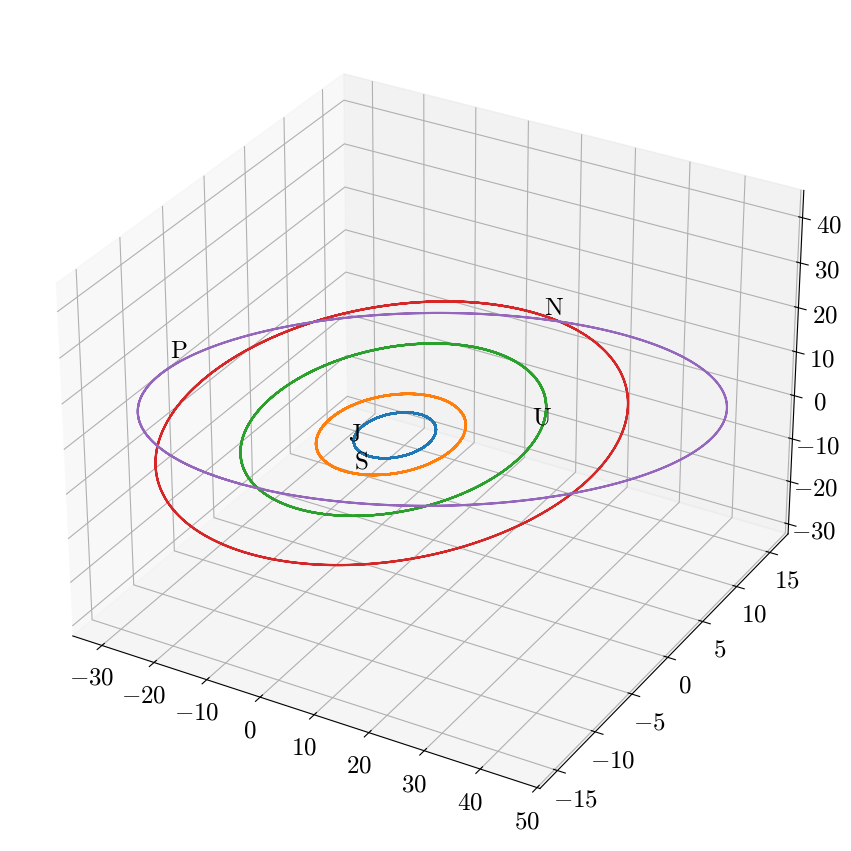

In [8]:
q, qdot = soln['u'].view(len(t), 2, solver.n_planets, 3).transpose(0, 1)

fig = plt.figure(figsize=(10.8, 10.8))
ax = fig.add_subplot(projection='3d')

for (i, qi) in enumerate(q.transpose(0,1)):
    x, y, z = qi.T
    ax.plot(y,z,x)
    ax.text3D(y[-1],z[-1],x[-1], names[i][0], ha='center', va='bottom')
(xlim, ylim, zlim) = (ax.get_xlim(), ax.get_ylim(), ax.get_zlim())

In [9]:
import numpy as np

q, qdot = soln['u'].view(len(t), 2, solver.n_planets, 3).transpose(0, 1)
q = q.detach().numpy()

timesteps_per_frame = 30

fig = plt.figure(figsize=(10.8, 10.8))
ax = fig.add_subplot(projection='3d')
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)

ax.grid(False)

ax.set_xlabel('$y$ / au')
ax.set_ylabel('$z$ / au')
ax.set_zlabel('$x$ / au')
title = ax.set_title(f'$t={t[0]/365:05.1f}$ years')

trails = [ax.plot([], [], [], lw=4, alpha=.2)[0] for _ in range(solver.n_planets)]
bodies = [ax.plot([], [], [], f'C{j}o', ms=16, lw=4)[0] for j in range(solver.n_planets)]
labels = [ax.text3D(0, 0, 0, name[0]) for name in names]

ax.plot(0, 0, 0, 'ko', ms=16)

def animate(i):
    idx = min(timesteps_per_frame*i, len(t))

    for j in range(solver.n_planets):
        trails[j].set_data(q[:idx,j,1], q[:idx,j,2])
        trails[j].set_3d_properties(q[:idx,j,0])

        bodies[j].set_data([q[idx,j,1]], [q[idx,j,2]])
        bodies[j].set_3d_properties([q[idx,j,0]])

        labels[j].set_position_3d((q[idx,j,1], q[idx,j,2], q[idx,j,0]))


    title.set_text(f'$t={t[idx]/365:05.1f}$ years')

    return (trails[0],)

ani = animation.FuncAnimation(fig, animate, frames=len(t)//timesteps_per_frame, blit=True)
ani.save('./assets/outer-solar.mp4', writer="ffmpeg", fps=60, dpi=100)

plt.close()
# HTML(ani.to_jshtml())